In [5]:
import matplotlib.pyplot as plt, pandas as pd, transforms as T
import argparse, os, torch, json
import numpy as np, random, torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from constants import *
from torchvision import transforms
from dataset import PhotoLoadingDataset
from torch.utils.data import DataLoader
from model import model_registry
from dataset import transforms_registry
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
log_folder = input("Log folder: ")
args = argparse.Namespace()
args_file = os.path.join(log_folder, LOGS_ARGS_FILE_NAME)
with open(args_file, "r") as f:
    args.__dict__ = json.load(f)


In [20]:
transforms = transforms_registry["test"](args.input_size)

selected_folders_df = pd.read_csv(SELECTED_FOLDERS_FOR_MODEL)
selected_folders = selected_folders_df[selected_folders_df["type"] == "train"]["folder"].astype(str).tolist()


dataset = PhotoLoadingDataset(FORMATTED_PHOTO_FOLDER, selected_folders, transform=transforms)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [21]:
model = model_registry[args.model]().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.load_state_dict(torch.load(os.path.join(log_folder, LOGS_MODEL_FILE_NAME)))
optimizer.load_state_dict(torch.load(os.path.join(log_folder, LOGS_OPTIMIZER_FILE_NAME)))

model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/tient/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100.0%


MobileNetV3SmallFreezed(
  (encoder): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
       

In [22]:
embeddings = []
labels = []
images = []
for i, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = [int(y_) for y_ in y]
    y = torch.tensor(y).to(device)   
    with torch.no_grad():
        output = model(x)
        embeddings.append(output)
        labels.append(y)
        images.append(x)
        

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)

embeddings = embeddings.cpu().numpy()
labels = labels.cpu().numpy()

images = torch.cat(images, dim=0)
images = images.cpu().numpy()

In [23]:
# tsne to visualize the embeddings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2, perplexity=20)

embeddings_tsne = tsne.fit_transform(embeddings)

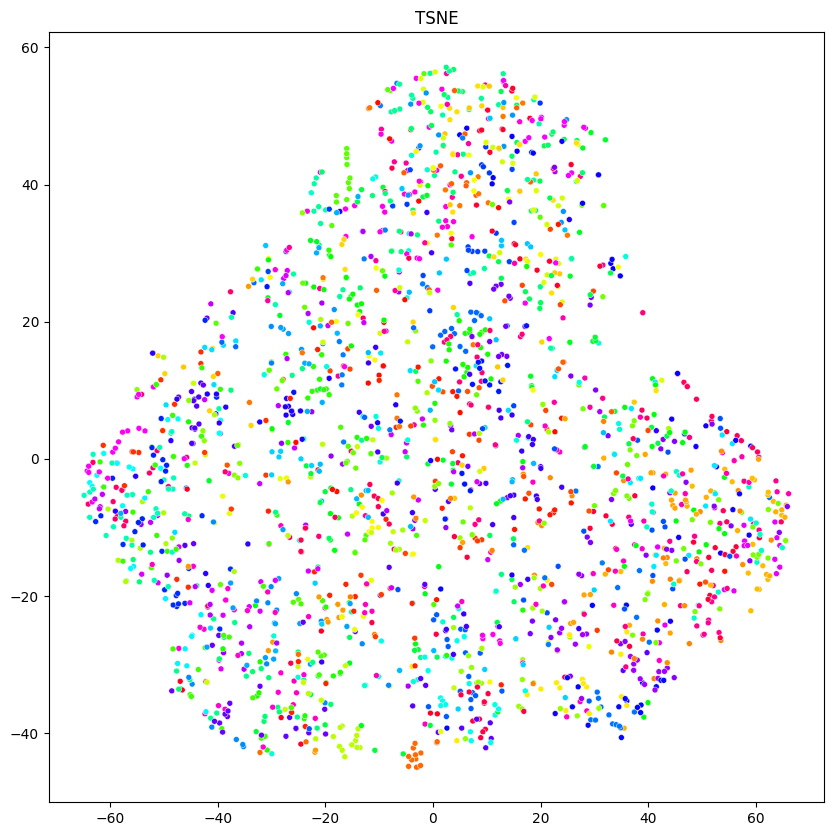

In [24]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=labels, size=1, palette=sns.color_palette("hsv", len(selected_folders)))
#sns.kdeplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=labels, palette=sns.color_palette("hsv", len(selected_folders)), fill=False, levels=1)
plt.title("TSNE")
plt.legend([],[], frameon=False)
plt.show()

In [30]:
# for each class, calculate the prototype, sort all the embeddings by distance to the prototype, then visualize the top 10
# select a random class
selected_class = np.random.choice(np.unique(labels))
print(selected_class)
selected_indices = np.where(labels == selected_class)[0]
selected_class_embeddings = embeddings[selected_indices]
selected_class_prototype = np.mean(selected_class_embeddings, axis=0)
selected_class_images = images[selected_indices]

# using euclidean distance
distances = [torch.norm(torch.tensor(selected_class_prototype) - torch.tensor(embedding)) for embedding in embeddings]
sorted_indices = np.argsort(distances)
selected_embeddings = embeddings[sorted_indices]
selected_images = [images[i] for i in sorted_indices]

284174


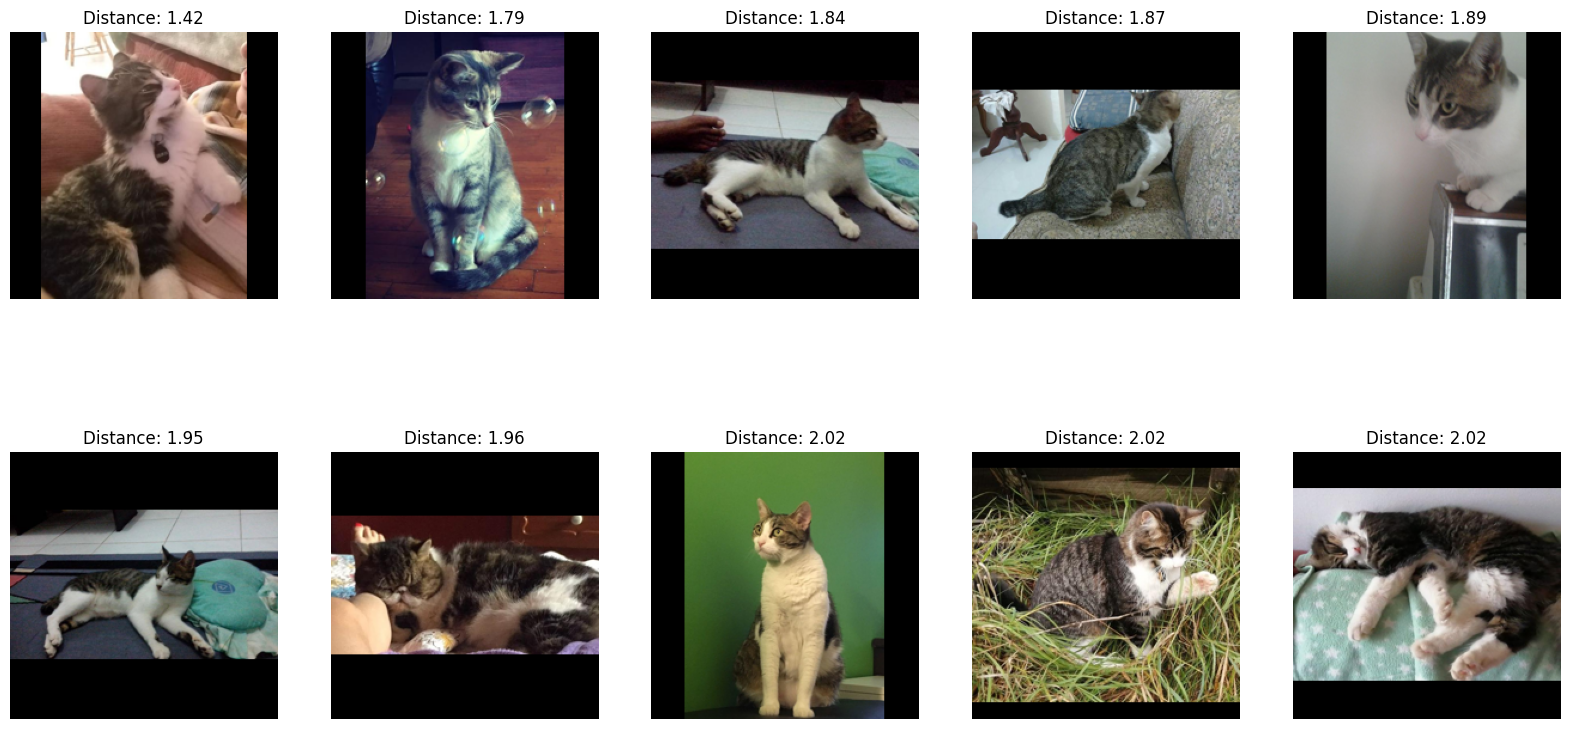

In [26]:
# visualize the top 10
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    if i >= len(selected_images):
        break
    
    ax.imshow(selected_images[i].transpose(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Distance: {distances[sorted_indices[i]]:.2f}")
plt.show()

/tmp/ipykernel_138981/2081385964.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(class_variances)), y=class_variances, palette=sns.color_palette("hsv", len(selected_folders)))


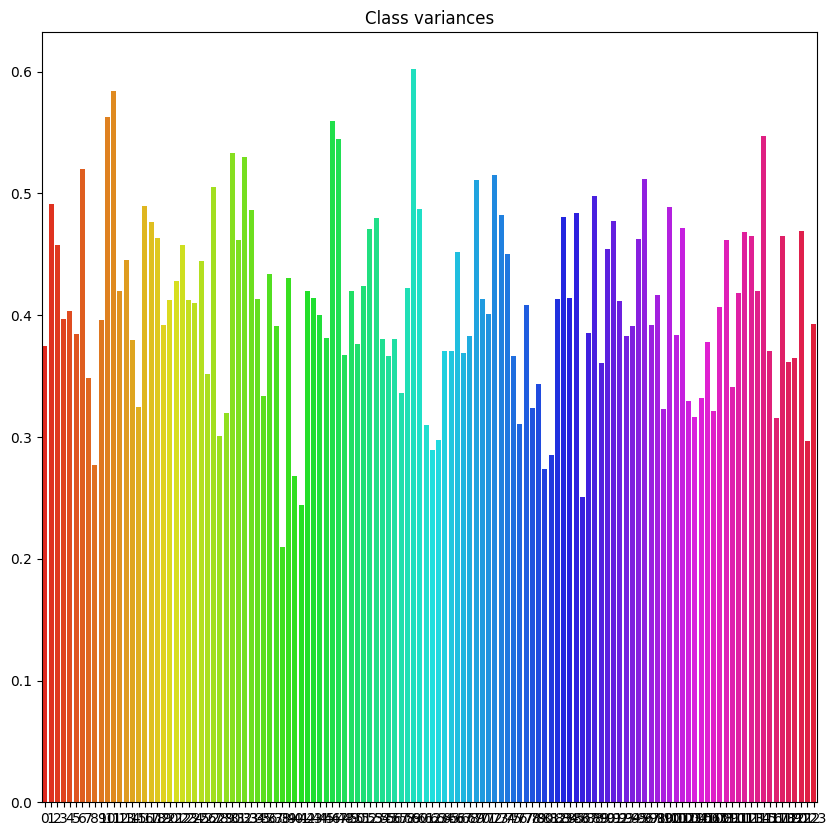

In [27]:
# for each class, calculate the variance of the embeddings
class_variances = []
for selected_class in np.unique(labels):
    selected_indices = np.where(labels == selected_class)[0]
    selected_class_embeddings = embeddings[selected_indices]
    class_variance = np.var(selected_class_embeddings, axis=0)
    class_variances.append(class_variance)
    
class_variances = np.array(class_variances)
class_variances = np.sqrt(np.sum(class_variances ** 2, axis=1))

plt.figure(figsize=(10, 10))
sns.barplot(x=np.arange(len(class_variances)), y=class_variances, palette=sns.color_palette("hsv", len(selected_folders)))
plt.title("Class variances")
plt.show()